[(0.2823529411764706, 0.47058823529411764, 0.8117647058823529),
 (0.41568627450980394, 0.8, 0.396078431372549),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.7058823529411765, 0.48627450980392156, 0.7803921568627451),
 (0.7686274509803922, 0.6784313725490196, 0.4),
 (0.4666666666666667, 0.7450980392156863, 0.8588235294117647)]

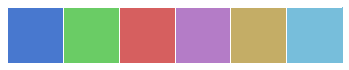

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import numpy as np
from event import Event
import seaborn as sns

sns.palplot(sns.color_palette("muted"))
sns.color_palette('muted')

# Convert to raw text file

import csv
import numpy as np

directory='./data/'
file_name='Chip4_HCT116_0021_0.005.atf'
output_file_name='Chip4_HCT116_0021_0.005'

header_length=10

file_length=file_len(directory+file_name)


file_handle=open(directory+file_name, 'r')

csv_reader = csv.reader(file_handle, delimiter='\t', quotechar='|')

output_filehandle=open(directory+output_file_name, 'w')



for i in range(header_length):
    line=csv_reader.next()
    
for row in csv_reader:
    output_filehandle.write(row[0] +'\t' + row[1] + '\n')    

# Load .atf

In [2]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    f.close()
    return i + 1

import csv
import numpy as np

directory='./data/'
file_name='Chip4_cell_0018.atf'

header_length=10

file_length=file_len(directory+file_name)


file_handle=open(directory+file_name, 'r')

csv_reader = csv.reader(file_handle, delimiter='\t', quotechar='|')



time=np.zeros(file_length-header_length)
current=np.zeros(file_length-header_length)
#current=np.zeros(MAX_SIZE)


for i in range(header_length):
    csv_reader.next()
i=0
for row in csv_reader:
    time[i]=row[0]
    current[i]=row[1]
    i+=1

# Load file

In [3]:
def open_full_atf_file(file_name):
    file_length=file_len(file_name)
    file_handle=open(directory+file_name, 'r')
    csv_reader = csv.reader(file_handle, delimiter='\t', quotechar='|')
    data=np.empty((file_length,2))
    i=0
    for row in csv_reader:
        data[i,0]=row[0]
        data[i,1]=row[1]
        i+=1
    
    return data


def open_raw_file(file_name, data_point_start=-1, data_point_end=-1):
    # open full file
    if data_point_start == -1:
        data_point_start=0
    if data_point_end == -1:
        data_point_end=file_len(file_name)
    print data_point_end
    
    data=np.empty((data_point_end-data_point_start,2))
        
    file_handle=open(file_name, 'r')
    csv_reader = csv.reader(file_handle, delimiter='\t', quotechar='|')
    
    for i in range(0, data_point_start):
        row=csv_reader.next()
    
    for i in range(0, data_point_end-data_point_start):
        row=csv_reader.next()
        try:
            data[i,0]=row[0]
            data[i,1]=row[1]
        except:
            print i
    
    return data

In [4]:
directory='./data/'
file_name='Chip4_HCT116_0021_0.005'
data=open_raw_file(directory+file_name, 1000, 1000000)
#data=open_full_atf_file(directory+file_name)

1000000


In [5]:
baseline_avg_length=200    # was 200
event_avg_length=5
trigger_sigma_threshold=5
max_search_length=1000
baseline=np.empty((0,4))

current_index=0
while current_index+baseline_avg_length <= data.shape[0]:
    baseline_avg=np.mean(data[current_index:current_index+baseline_avg_length,1])
    baseline_sigma=np.std(data[current_index:current_index+baseline_avg_length,1])
    baseline=np.vstack((baseline, [[data[current_index,0], baseline_avg,\
                                    baseline_avg-1.*trigger_sigma_threshold*baseline_sigma,\
                                    baseline_avg+1.*trigger_sigma_threshold*baseline_sigma]]))
    current_index+=baseline_avg_length

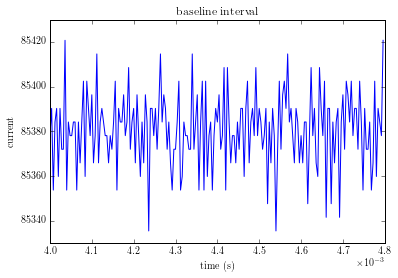

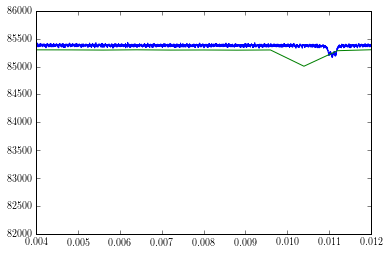

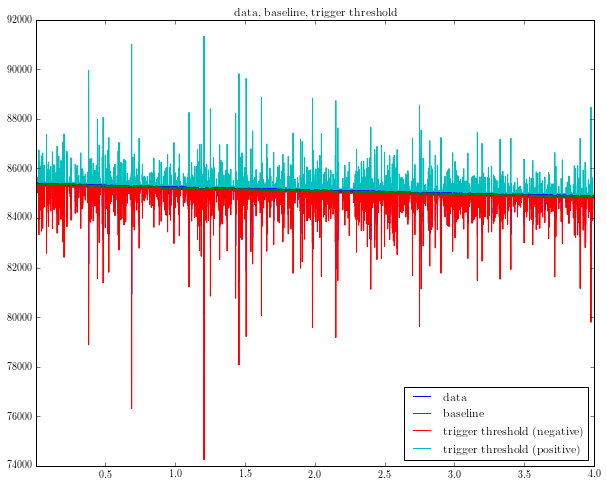

In [6]:
# Plot current over interval used to calculate the baseline
plt.plot(data[:baseline_avg_length,0], data[:baseline_avg_length,1])

plt.title('baseline interval')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('time (s)')
plt.ylabel('current')

plt.show()

# Plot close up
a=0
b=2000
plt.plot(data[a:b,0], data[a:b,1])
#plt.plot(baseline[a:b,0], baseline[:,1], label='baseline')
plt.plot(baseline[:,0], baseline[:,2], label='trigger threshold (negative)')
#plt.plot(baseline[a:b,0], baseline[:,3], label='trigger threshold (positive)')
plt.xlim(data[a,0],data[b,0])
plt.ylim(82000,86000)
plt.show()

# Plot baseline and trigger value
fig=plt.figure(figsize=(10,8))
plt.plot(data[:,0], data[:,1], label='data')
plt.plot(baseline[:,0], baseline[:,1], label='baseline')
plt.plot(baseline[:,0], baseline[:,2], label='trigger threshold (negative)')
plt.plot(baseline[:,0], baseline[:,3], label='trigger threshold (positive)')

plt.xlim(data[0,0], data[-1,0])

plt.legend(loc='lower right')

plt.title('data, baseline, trigger threshold')
plt.show()

# Find events

## Method 1: Scanning

In [7]:
event_indices=np.empty((0,2),dtype=int)
baseline=np.empty((0,4), dtype=float)

current_index=0
baseline_avg=np.mean(data[current_index:current_index+baseline_avg_length,1])
baseline_sigma=np.std(data[current_index:current_index+baseline_avg_length,1])
trigger_threshold=trigger_sigma_threshold*baseline_sigma
baseline=np.vstack((baseline, np.array([[data[current_index,0], baseline_avg, baseline_avg-trigger_threshold,\
                                       baseline_avg+trigger_threshold]], dtype=float)))

keep_going = True
while keep_going == True:
    # Look for possible event
    start_trigger_found = False
    while start_trigger_found == False:
        # Current exceeds trigger threshold
        if abs(data[current_index,1]-baseline_avg) >= trigger_threshold:
            
            # Check to see which updated baseline to compare to
            if event_indices.shape[0]>0:
                if current_index-2*baseline_avg_length >= event_indices[-1,-1]:
                    
                    # Update baseline (i.e. in case of drift)
                    baseline_avg=np.mean(data[current_index-2*baseline_avg_length:current_index-baseline_avg_length,1])
                    baseline_sigma=np.std(data[current_index-2*baseline_avg_length:current_index-baseline_avg_length,1])
                    trigger_threshold=trigger_sigma_threshold*baseline_sigma
                    baseline=np.vstack((baseline, np.array([[data[current_index,0], baseline_avg, baseline_avg-1.*trigger_threshold,\
                                       baseline_avg+1.*trigger_threshold]], dtype=float)))
                else: 
                    print 'baseline conflict!'
                    
            else:
                # Update baseline (i.e. in case of drift)
                    baseline_avg=np.mean(data[current_index-2*baseline_avg_length:current_index-baseline_avg_length,1])
                    baseline_sigma=np.std(data[current_index-2*baseline_avg_length:current_index-baseline_avg_length,1])
                    trigger_threshold=trigger_sigma_threshold*baseline_sigma
                    baseline=np.vstack((baseline, np.array([[data[current_index,0], baseline_avg, baseline_avg-1.*trigger_threshold,\
                                       baseline_avg+1.*trigger_threshold]], dtype=float)))
                
            
            # Point still exceeds trigger threshold
            if abs(data[current_index,1]-baseline_avg) >= trigger_threshold: 
                # Trigger, get first point to exit baseline
                event_avg=np.mean(data[current_index-event_avg_length:current_index,1])
                while start_trigger_found == False:
                    if abs(event_avg)>=abs(baseline_avg):
                        print 'event #', event_indices.shape[0]
                        
                        start_index=current_index-event_avg_length/2+1
                        print '\tstart time:', data[start_index,0]
                        start_trigger_found = True
                    else:
                        event_avg=np.mean(data[current_index-event_avg_length:current_index,1])
                        current_index-=1
            else:
                print 'cancelled event...'
                
        current_index+=1
            
    
    
    # Look for possible event end
    stop_trigger_found = False
    event_avg=np.mean(data[current_index:current_index+event_avg_length,1])
    while stop_trigger_found == False:     
        # Still in event
        if abs(event_avg) <= abs(baseline_avg):
            current_index+=1
            event_avg=np.mean(data[current_index:current_index+event_avg_length,1])
        
        # Event end found
        else:
            stop_trigger_found = True
            stop_index=current_index+event_avg_length/2
            current_index=stop_index+5#1
            event_indices=np.vstack((event_indices, [[start_index, stop_index]]))
            
        # Maximum search length
        if current_index-start_index >= max_search_length:
            print 'hit maximum search length...\n'
            print '\tcurrent_index=', current_index, 'start_index=', start_index, '\n'
            stop_trigger_found = True
            current_index=start_index+max_search_length #remove max search length
            baseline_avg=np.mean(data[current_index:current_index+baseline_avg_length,1])
            baseline_sigma=np.std(data[current_index:current_index+baseline_avg_length,1])
            trigger_threshold=trigger_sigma_threshold*baseline_sigma
            baseline=np.vstack((baseline, np.array([[data[current_index,0], baseline_avg, baseline_avg-1.*trigger_threshold,\
                                       baseline_avg+1.*trigger_threshold]], dtype=float)))       
            
    #print '\tt=', data[event_indices[-1,0],0]
    #print '\t', event_indices[-1,0], event_indices[-1,1], event_indices[-1,1]-event_indices[-1,0]

event # 0
	start time: 0.010788
cancelled event...
event # 1
	start time: 0.023212
event # 2
	start time: 0.02902
baseline conflict!
event # 3
	start time: 0.031196
baseline conflict!
event # 4
	start time: 0.032272
cancelled event...
event # 5
	start time: 0.03988
baseline conflict!
event # 6
	start time: 0.042052
baseline conflict!
event # 7
	start time: 0.04446
baseline conflict!
event # 8
	start time: 0.04584
event # 9
	start time: 0.049408
baseline conflict!
event # 10
	start time: 0.05104
baseline conflict!
event # 11
	start time: 0.052924
event # 12
	start time: 0.060284
cancelled event...
event # 13
	start time: 0.078052
event # 14
	start time: 0.088992
baseline conflict!
event # 15
	start time: 0.090008
hit maximum search length...

	current_index= 22502 start_index= 21502 

event # 15
	start time: 0.097448
event # 16
	start time: 0.104508
event # 17
	start time: 0.108704
cancelled event...
event # 18
	start time: 0.12056
event # 19
	start time: 0.13158
baseline conflict!
even

IndexError: index 999000 is out of bounds for axis 0 with size 999000

## Create event list

In [8]:
events=[]
for i in range(event_indices.shape[0]):
    events.append(Event())
    new_event=events[-1]
    new_event.set_start_stop_index(event_indices[i,0], event_indices[i,1])
    new_event.set_data(data[event_indices[i,0]:event_indices[i,1],:])

## Filter events

In [9]:
event_threshold_length=50

In [10]:
old_len=len(events)
events=[event for event in events if event._length >= event_threshold_length]
new_len=len(events)
print 'old size:', old_len, 'new size:', new_len

old size: 728 new size: 728


## Plot events, baseline

/home/preston/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


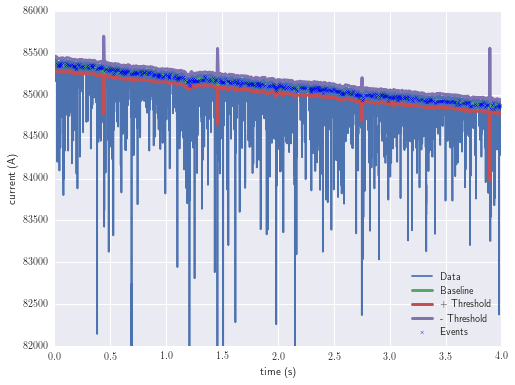

In [42]:
delta=500
'''
for i in range(len(events)):
    event=events[i]
    plt.plot(data[event._start_index-delta:event._stop_index+delta,0], data[event._start_index-delta:event._stop_index+delta,1],\
         c=(0,0,1))
    plt.plot(event._data[:,0], event._data[:,1], c=(1,0,0), label='Event '+str(i))
    plt.xlim(data[event._start_index-delta,0],data[event._stop_index+delta,0])
    

    
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('time (s)')
    plt.ylabel(r'current ($\micro$A)')
    plt.legend(loc='lower left')
    plt.show()
#'''


fig=plt.figure(figsize=(8,6))
plt.plot(data[:,0], data[:,1], zorder=1, label=r'Data')
plt.scatter(data[event_indices[:,0],0], data[event_indices[:,0],1], s=10, marker='x', zorder=11, label=r'Events')
plt.plot(baseline[:,0], baseline[:,1], lw=3, label=r'Baseline', zorder=10)
plt.plot(baseline[:,0], baseline[:,2], lw=3, label=r'+ Threshold', zorder=10)
plt.plot(baseline[:,0], baseline[:,3], lw=3, label=r'- Threshold', zorder=10)
b=data.shape[0]/1.-1
plt.xlim(data[0,0], data[b,0])
plt.ylim(82000,86000)


plt.legend(loc='lower right', numpoints=1)
plt.xlabel(r'time (s)')
plt.ylabel(r'current ($\micro$A)')

plt.show()

In [ ]:
a=200000
b=300000
fig=plt.figure(figsize=(8,6))
plt.plot(data[a:b,0], data[a:b,1], zorder=1, label='Data')
plt.plot(baseline[:,0], baseline[:,1], lw=3, label='Baseline', zorder=10)
plt.plot(baseline[:,0], baseline[:,2], lw=3, label='+ Threshold')
plt.plot(baseline[:,0], baseline[:,3], lw=3, label='- Threshold')
plt.xlim(data[a,0], data[b,0])


#plt.legend(loc='lower left')
plt.xlabel('time (s)')
plt.ylabel(r'current ($\micro$A)')

plt.show()

# Find peaks

## Method 3: Clustering and segmentation

### Clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
for i in range(len(events)):
    model=KMeans(n_clusters=3)
    events[i].set_predictions(model.fit_predict(events[i]._data[:,1].reshape(-1,1)).reshape(-1,1))
    events[i].set_levels(model.cluster_centers_)

### Segmentation

In [ ]:
max_separation_length=10

In [ ]:
for i in range(len(events)):
    event=events[i]
    level=event._predictions[0,0]
    for j in range(event._data.shape[0]):
        if event._predictions[j,0] == level:
            j=0
        else:
            j+=1
        if j == max_separation_length:
            level=event._predictions[j,0]
            event._split_list.append(j-max_separation_length)
            j=0

In [ ]:
for i in range(len(events)):
    event=events[i]
    plt.scatter(event._data[:,0], event._data[:,1], c=event._predictions[:,0], zorder=10)


    for j in range(event._levels.shape[0]):
        plt.plot([-1000,1000],[event._levels[j], event._levels[j]], lw=5)

    for j in range(len(event._split_list)):
        time=event._data[event._split_list[j],0]
        plt.plot([time,time], [-1000000000,1000000000], ls='--', c=(.2,.2,.2))
    
    plt.title('event '+str(i))
    
    plt.xlim(event._data[0,0], event._data[-1,0])    
    plt.ylim(event._data[:,1].min(), event._data[:,1].max())
    plt.show()